In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score

In [84]:
folder = 'results_final_halo_010222'
run='Sage_vlarge_all_4t_quantile_raw_final_kpqbad'

In [85]:
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    

In [86]:
os.listdir(pointer)

["performance_ne300_['sfr_100'].png",
 'Sage_vlarge_all_4t_quantile_raw_final_kpqbad',
 'events.out.tfevents.1643790149.tiger-i20g11.6802.14',
 'construct_dict.pkl',
 'trained_model',
 'result_dict.pkl']

In [87]:
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))

In [88]:
# ys, pred, targets = results['ys'], results['pred'], config["data_params"]['targets']
ys, pred, var = results['low_ys'], results['low_pred'], results['vars'].detach().cpu().numpy()

In [89]:
cols_t=np.array(['M_star', 'v_disk', 'm_cold gas', 'sfr_ave100Myr'])
    
def multi_base(ys, pred, targets):
    n_t = len(targets)
    figs=[]
    for n in range(n_t):
        fig, ax =plt.subplots(1,2, figsize=(12,6))
        ax=ax.flatten()
        ax[0].plot(ys[:,n],pred[:,n], 'ro', alpha=0.3)
        ax[0].plot([min(ys[:,n]),max(ys[:,n])],[min(ys[:,n]),max(ys[:,n])], 'k--', label='Perfect correspondance')
        ax[0].set(xlabel='SAM Truth',ylabel='GNN Prediction', title=cols_t[targets[n]])
        yhat=r'$\hat{y}$'
        ax[0].text(0.6,0.15, f'Bias (mean(y-{yhat})) : {np.mean(ys[:,n]-pred[:,n]):.3f}', transform=ax[0].transAxes)
        ax[0].text(0.6,0.1, r'$\sigma$ :  '+f'{np.std(ys[:,n]-pred[:,n]):.3f}', transform=ax[0].transAxes)
        ax[0].legend()
        vals, x, y, _ =ax[1].hist2d(ys[:,n],pred[:,n],bins=50, norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
        X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
        ax[1].contour(X,Y, np.log(vals.T+1), levels=10, colors='black')
        ax[1].plot([min(ys[:,n]),max(ys[:,n])],[min(ys[:,n]),max(ys[:,n])], 'k--', label='Perfect correspondance')
        ax[1].set(xlabel='SAM Truth',ylabel='GNN Prediction', title=cols_t[targets[n]])
        ax[1].legend()
        fig.tight_layout()
        figs.append(fig)
    return figs

In [90]:
# figs=multi_base(mstar_ys[mask],mstar_pred[mask],[0])

bias 0.0024826152
std 0.39281788
rho 0.9197516925698473
r2 0.8459169193745658
pct 0.48915540851024725


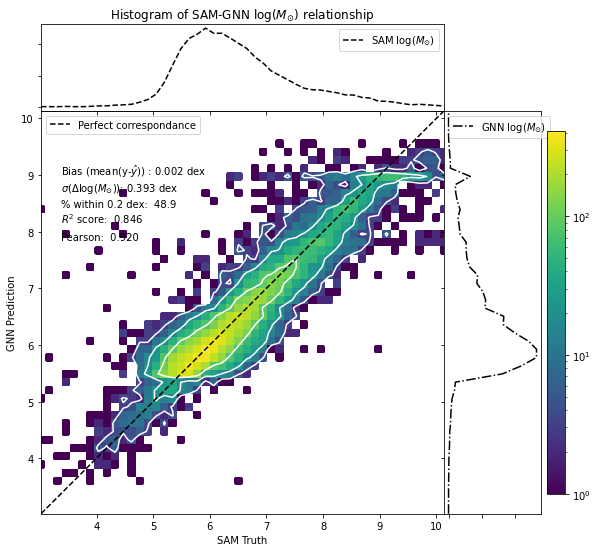

In [91]:
from matplotlib.ticker import NullFormatter
from scipy import stats

ys[:,0]+=9
pred[:,0]+=9

n=0
target=r"log($M_{\odot}$)"
# target=r"$v_{disk}$"

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
bottom_h = left_h = left + width
# rect_Cbar = [0, bottom, 0.1, height]
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.15]
rect_histy = [left_h, bottom, 0.15+0.06, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))
# axCbar = plt.axes(rect_Cbar)
axHist = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

bins=50
l=0.01
xt=0.05
yt=0.8
n_contour=4
# the scatter plot:
vals, x, y, hist =axHist.hist2d( ys[:,n], pred[:,n],bins=bins, range=[np.percentile(np.hstack([ys[:,n],pred[:,n]]), [0+l,100-l]),
                            np.percentile(np.hstack([ys[:,n],pred[:,n]]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
axHist.plot([min(ys[:,n]),max(ys[:,n])],[min(ys[:,n]),max(ys[:,n])], 'k--', label='Perfect correspondance')
axHist.set(xlabel='SAM Truth',ylabel='GNN Prediction')
axHist.legend()

# now determine nice limits by hand:
X, Y = X[0], Y.T[0]
axHist.set_xlim((min(X), max(X)))
axHist.set_ylim((min(Y), max(Y)))
yhat=r'$\hat{y}$'
pct=np.sum(np.abs((ys[:,n]-pred[:,n]))<0.2)/len(ys[:,n]-pred[:,n])

r2=r2_score(ys[:,n],pred[:,n])
rho = np.corrcoef(ys[:,n],pred[:,n])[0,1]

print('bias', np.mean(ys-pred))
print('std', np.std(ys-pred))
print('rho', rho)
print('r2', r2)
print('pct',pct)
        
axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(ys[:,n]-pred[:,n]):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(ys[:,n]-pred[:,n]):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



# axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
# axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
ys_kde = stats.gaussian_kde(ys[:,n], 0.05)
pred_kde = stats.gaussian_kde(pred[:,n], 0.05)
axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN {target}')
axHistx.legend()
axHisty.legend(loc='upper left')

axHistx.set(title=f'Histogram of SAM-GNN {target} relationship')

axHistx.set_xlim(axHist.get_xlim())
axHisty.set_ylim(axHist.get_ylim())

plt.colorbar(hist, ax=axHisty, location='right')

plt.show()

In [83]:
(ys[:,n]-pred[:,n])>0.2

array([ True, False, False, ..., False, False, False])

In [66]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats

def single_plot(yss, preds):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(10, 8))
#     ax = ax.flatten()
#     target=r"log($SFR/M_{\odot}/yr$)"
#     targets=[r"$log(v_{disk})$", r"log($M_{cold}/M_{\odot}$)", r"log($SFR/M_{\odot}/yr$)"]
    targets=[r"$M_{*}$"]
    target=targets[0]
    ys = yss
    pred = preds
    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.15, 0.67
    bottom, height = 0.0, 0.75
    bottom_h = bottom +height
    left_h = left + width
    # rect_Cbar = [0, bottom, 0.1, height]
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15+0.12, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

    # start with a rectangular Figure
    ax.set_axis_off()
    # axCbar = plt.axes(rect_Cbar)
    axHist = ax.inset_axes(rect_scatter)
    axHistx = ax.inset_axes(rect_histx)
    axHisty = ax.inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    axHistx.yaxis.set_major_formatter(nullfmt)
    axHisty.xaxis.set_major_formatter(nullfmt)

    bins=50
    l=0.0
    n_contour=3
    # the scatter plot:
    vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
    X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
    axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
    axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
    axHist.set(xlabel=f'SAM {target}',ylabel=f'GNN {target}')
    axHist.legend()

    X, Y = X[0], Y.T[0]
    axHist.set_xlim((min(X), max(X)))
    axHist.set_ylim((min(Y), max(Y)))
    yhat=r'$\hat{y}$'

    #calculate metrics
    pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
    r2=r2_score(ys,pred)
    rho = np.corrcoef(ys,pred)[0,1]
    print('bias', np.mean(ys-pred))
    print('std', np.std(ys-pred))
    print('pct', pct)
    print('r2', r2)
    print('rho', rho)
    xt=0.05
    yt=0.8
    dy=0.07
    font = {'weight': 'normal',
        'size': 13}

    axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.2f} dex', fontdict=font, transform=axHist.transAxes)
    axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
    axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.2f}', fontdict=font, transform=axHist.transAxes)
#             axHist.text(xt,yt-3*dy, r'$R^2$:  '+f'{r2:.3f}', fontdict=font, transform=axHist.transAxes)

#             axHist.text(xt,yt-4*dy, '% < 0.2 dex:  '+f'{pct*100:.1f}', fontdict=font, transform=axHist.transAxes)


    # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
    # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
    ys_kde = stats.gaussian_kde(ys, 0.1)
    pred_kde = stats.gaussian_kde(pred, 0.1)
    axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM')
    axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN')
    axHistx.legend()
    axHisty.legend(loc='upper left')

    axHistx.set(title=f'SAM-GNN {target} relationship')

    axHistx.set_xlim(axHist.get_xlim())
    axHisty.set_ylim(axHist.get_ylim())

    divider = make_axes_locatable(axHisty)
    cax = divider.append_axes("right", size="15%", pad=0.18)
    divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

    # Plot vertical colorbar
    plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    return fig

In [47]:
k=0
mstar_ys = ys[:,k]
mstar_pred = pred[:,k]
mstar_var = var[:,k]
mask=mstar_var<np.median(mstar_var)
# mask=mstar_var<100

bias -0.0007489745
std 0.014236248
pct 0.9999080966822902
r2 0.9938556857100791
rho 0.9969316949011022


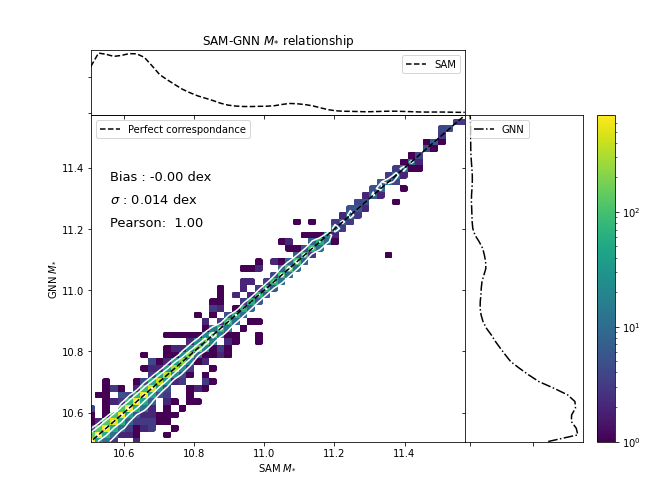

In [48]:
fig = single_plot(mstar_ys[mask], mstar_pred[mask])

bias -0.00017794874
std 0.04975205
pct 0.9989890635051926
r2 0.9080316925485695
rho 0.9529092727482233


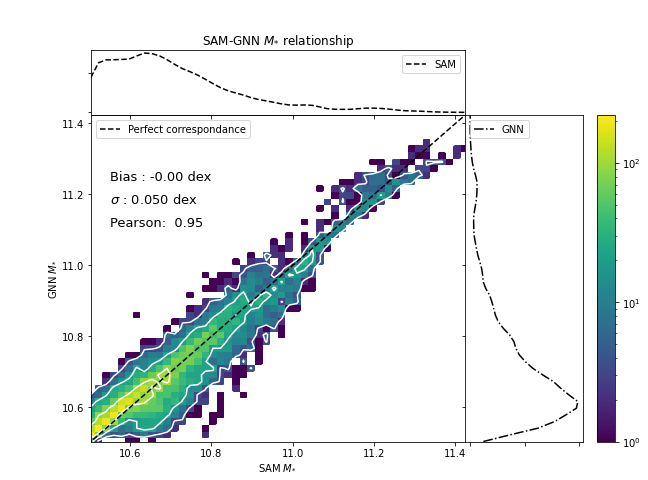

In [49]:
fig = single_plot(mstar_ys[~mask], mstar_pred[~mask])

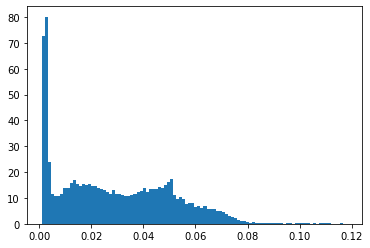

In [50]:
plt.hist(mstar_var, bins=100, density=1);
# plt.yscale('log')
plt.vlines(np.median(mstar_var), 1e-2,10)

In [16]:
np.percentile(mstar_var, np.arange(0,110, 10))

array([0.00475287, 0.01652921, 0.01892106, 0.0211167 , 0.02350153,
       0.02645934, 0.03066506, 0.03685608, 0.04745851, 0.07144206,
       1.18420315])